# CSPB 3202 - Final Project 

## Reinforcement Learning - Lunar Lander

### Table of Contents

1. Overview
2. Approach
3. Results
4. Conclusion
5. References

### Overview

In this project I'm going to be creating an agent to control the Lunar Lander Box2D environment from Gymnasium. The Lunar Lander environment can be referenced here: 

https://gymnasium.farama.org/environments/box2d/lunar_lander/

To begin I will implement a random agent to control the Lunar Lander. Then I will implement a heruistic agent. Finally I will implement a reinforcement learning model. 

#### Lunar Lander Environment Description

**Objective**

The objective of the Lunar Landar Environment is to land between the flags. 

**Action Space**

There are 4 actions that can be taken:

* 0: Do Nothing
* 1: Fire Left Engine
* 2: Fire Main Engine
* 3: Fire Right Engine

**Obervables**

Example obervable:

```Box([ -2.5 -2.5 -10. -10. -6.2831855 -10. -0. -0. ], [ 2.5 2.5 10. 10. 6.2831855 10. 1. 1. ], (8,), float32)```

Decoded values:
|Definition|Value|
|:---------|:----|
|x coordinate|-2.5|
|y coordinate|-2.5|
|x linear velocity|-10|
|y linear velocity|-10|
|angle|-6.2831855|
|angular velocity|-10|
|leg one touchdown|0|
|leg two touchdown|0|

**Reward Criteria**

Each step the following items impact the reward.

- Distance from landing pad
- Movement speed
- Lander tilt
- Contact of each leg
- Number of times the engines are fired
- Landing safely

The total reward is the sum of all the rewards for all steps in the episode. OpenAI states that an episode is considered a solution of it scores at least 200 points. 

**Termination Criteria**

The episode is terminated if the lander crashes, it gets outside the viewpoint, or it's not active.


### Approach

To begin I'm going to start with the random agent. This will allow me to get my environment set up and have a good starting point for this project.

My project is organized as the following:

|File/Folder|Purpose|
|:---------|:----|
|franco_final_project.ipynb|A jupyter notebook containing my final project deliverables|
|scripts|A folder containing python scripts I have created|
|utils|A folder containing useful utilities I've created to assist with this assignemnt|
|ai_env.yml|An export of my conda environment. It can be imported on different machines. See README|
|assignment_definition|A folder containing project details given to us by the professor|
|gym_demos|A folder containing demos from the openAI gym website|






Running 10 episodes...
Saving vides to: videos/lunarLander_random

Episode 1: 62 steps, reward = -210.8796846810141, success: False 
Episode 2: 92 steps, reward = -214.31565687522846, success: False 
Episode 3: 111 steps, reward = -248.39137587604412, success: False 
Episode 4: 125 steps, reward = -19.98281008592437, success: False 
Episode 5: 73 steps, reward = -126.34508857551859, success: False 
Episode 6: 85 steps, reward = -120.34492709436587, success: False 
Episode 7: 104 steps, reward = -105.8004190987128, success: False 
Episode 8: 123 steps, reward = -206.89575383264616, success: False 
Episode 9: 83 steps, reward = -324.3694180652404, success: False 
Episode 10: 87 steps, reward = -119.0251732161064, success: False 


MoviePy - Building file  videos/lunarLander_random/rand-episode-0.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: videos/lunarLander_random/rand-episode-0.gif.

Displaying gif from episode 1:


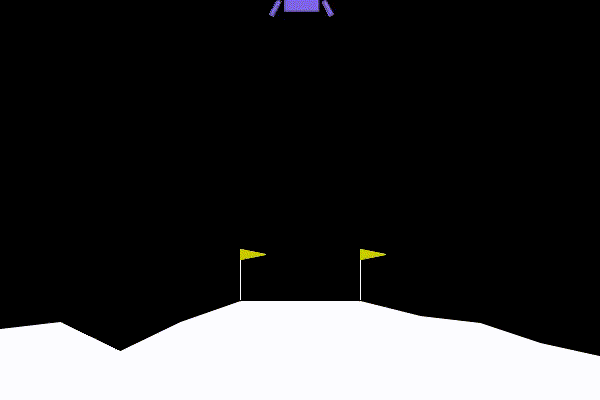

In [1]:
import gymnasium as gym
from gymnasium.wrappers import  RecordVideo
from IPython.display import Image
from moviepy.editor import VideoFileClip

# Initialise the Lunar Lander Environment 
env = gym.make("LunarLander-v3", render_mode="rgb_array")
num_of_episodes = 10
folder="videos/lunarLander_random"


# install env wrapper to record a video
env = RecordVideo(
    env,
    video_folder=folder,                  # Folder
    name_prefix="rand",                   # Video filename prefix
    episode_trigger=lambda x: True        # Record every episode
)

print(f"Running {num_of_episodes} episodes...")
print(f"Saving vides to: {folder}\n")

# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    observation, info = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False

    while not episode_over:
        # For now we will use a random agent
        action = env.action_space.sample()

        # Take the random action and recieve information 
        observation, reward, terminated, truncated, info = env.step(action)
        total_score = total_score + reward

        num_of_steps += 1

        episode_over = terminated or truncated

    # The documentation states that a score of 200 or more is a solution
    success_criteria = reward >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")


env.close()
print("\n")

# convert the first mp4 to a gif and show it
first_video = VideoFileClip("videos/lunarLander_random/rand-episode-0.mp4")
#first_video = first_video.resize(0.5)
first_video.write_gif("videos/lunarLander_random/rand-episode-0.gif", program="ffmpeg")

print("\nDisplaying gif from episode 1:")
Image(filename="videos/lunarLander_random/rand-episode-0.gif")

In this script I executed 10 episodes with an agent that performs random actions. For each set I output some simple metrics. We can see the number of steps taken, total reward for the episode, and if it's a valid solution. The gymnasium documentation defines a valid solution as a score of 200 or greater. For each episode I saved a mp4 video in the video/lunarLander_random directory. Finally I displayed the first episode as a gif embedded in this jupyter notebook. 

Visual inspection of the gif from the first epsiode shows the lander immediately crashing. It's score was under the 200 threshold and was a failure. In fact all 10 episodes are considered a failure. Which is expected a random agent can't properly land. 

#### Heuristic Agent

Let's see if we can implement a heuristic agent that can do better. 

We've already defined all of the obervable values in the section above. Let's pull them out of the env so we can closer evaluate them. 




In [2]:

from collections import namedtuple

# Create a named tuple to hold observation data
Observation = namedtuple("Observation", ["x", "y", "x_vel", "y_vel", "angle", "angular_vel", "touch1", "touch2"])

# Initialise the Lunar Lander Environment this time with a limit on episode steps
env = gym.make("LunarLander-v3", max_episode_steps=20)
num_of_episodes = 1


print(f"Running {num_of_episodes} episodes...")

# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    observation, info = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False


    while not episode_over:
        # For now we will use a random agent
        action = env.action_space.sample()

        # Take the random action and recieve information 
        observation, reward, terminated, truncated, info = env.step(action)

        # Put observation into the named tuple I created
        obs_tuple = Observation(*observation)
        
        # Print observation for examination
        print(f"observation: {obs_tuple}")

        total_score = total_score + reward

        num_of_steps += 1

        episode_over = terminated or truncated

    # The documentation states that a score of 200 or more is a solution
    success_criteria = reward >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")


env.close()
print("\n")

Running 1 episodes...
observation: Observation(x=np.float32(-0.00693388), y=np.float32(1.3896624), x_vel=np.float32(-0.35068223), y_vel=np.float32(-0.48522052), angle=np.float32(0.007954226), angular_vel=np.float32(0.07861555), touch1=np.float32(0.0), touch2=np.float32(0.0))
observation: Observation(x=np.float32(-0.010330868), y=np.float32(1.379028), x_vel=np.float32(-0.34403205), y_vel=np.float32(-0.47267228), angle=np.float32(0.012242174), angular_vel=np.float32(0.0857668), touch1=np.float32(0.0), touch2=np.float32(0.0))
observation: Observation(x=np.float32(-0.013727951), y=np.float32(1.3677934), x_vel=np.float32(-0.34404466), y_vel=np.float32(-0.49935254), angle=np.float32(0.016529305), angular_vel=np.float32(0.085750654), touch1=np.float32(0.0), touch2=np.float32(0.0))
observation: Observation(x=np.float32(-0.017035102), y=np.float32(1.3559613), x_vel=np.float32(-0.33276728), y_vel=np.float32(-0.52589285), angle=np.float32(0.018551473), angular_vel=np.float32(0.04044704), touch1=n

Here I ran through 20 states to get an idea of the different observables. I put the observation data into a named tuple. I'm hoping that this will make it easier to decode and use. 

The objective here is to land between the flags. So with this heuristic agent I can adjust left and right if I'm in the wrong area. I can know the position with the x and y values. I think if the body of the lander hits the ground it's a negative reward. So I need to keep track of if I'm landing flat. I can look at the angle values to determin that. Finally the lander will also crash if it's decending too rapidly. I can determin it's fall speed with x_vel. 

So overall, given a state I want to do the following:

- Not between the flags: Adjust course
- Not landing flat: straighten the lander
- decending too rapidly: slow down



Running 10 episodes...
Saving vides to: videos/lunarLander_heuristic

Episode 1: 229 steps, reward = 2.6707501864968037, success: False 
Episode 2: 214 steps, reward = -6.567198951112829, success: False 
Episode 3: 214 steps, reward = 5.334361921089567, success: False 
Episode 4: 223 steps, reward = -49.99599192633924, success: False 
Episode 5: 172 steps, reward = -11.21474871125558, success: False 
Episode 6: 214 steps, reward = -25.944926588916957, success: False 
Episode 7: 361 steps, reward = 237.96214449403433, success: True 
Episode 8: 231 steps, reward = -27.37521028372106, success: False 
Episode 9: 213 steps, reward = -14.016861694898111, success: False 
Episode 10: 226 steps, reward = -24.613027161713376, success: False 


MoviePy - Building file  videos/lunarLander_heuristic/heuristic-episode-0.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: videos/lunarLander_heuristic/heuristic-episode-0.gif.

Displaying gif from episode 1:


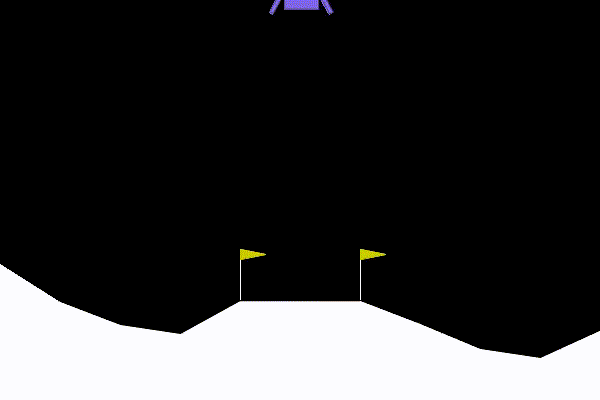

In [3]:

from enum import Enum
import random

# Create a named tuple to hold observation data
Observation = namedtuple("Observation", ["x", "y", "x_vel", "y_vel", "angle", "angular_vel", "touch1", "touch2"])

# Create enum for action space
class LunarAction(Enum):
    IDLE = 0
    FIRE_RIGHT = 1
    FIRE_MAIN = 2
    FIRE_LEFT = 3


def lunar_heuristic(obs):
    obs_tuple = Observation(*obs)

    # Prioity 0: If touch down do nothing
    if obs_tuple.touch1 and obs_tuple.touch2:
        return LunarAction.IDLE.value

    # Priority 1: Control Fall Speed
    if obs_tuple.y_vel < -.3:
        return LunarAction.FIRE_MAIN.value
    
    # Priority 2: Too much tilt
    if obs_tuple.angle > .15:
        return LunarAction.FIRE_LEFT.value
    if obs_tuple.angle < -.15:
        return LunarAction.FIRE_RIGHT.value

    # Priorty 3: Not between flags
    if obs_tuple.x < -.15:
        return LunarAction.FIRE_LEFT.value
    if obs_tuple.x > .15:
        return LunarAction.FIRE_RIGHT.value
    
    
  
    return LunarAction.IDLE.value
    



# Initialise the Lunar Lander Environment 
env = gym.make("LunarLander-v3", render_mode="rgb_array")
num_of_episodes = 10
folder="videos/lunarLander_heuristic"


# install env wrapper to record a video
env = RecordVideo(
    env,
    video_folder=folder,                  # Folder
    name_prefix="heuristic",              # Video filename prefix
    episode_trigger=lambda x: True        # Record every episode
)

print(f"Running {num_of_episodes} episodes...")
print(f"Saving vides to: {folder}\n")

# Repeat for set number of episodes
for episode_count in range(num_of_episodes):
    # We need to reset the environment before first use
    observation, info = env.reset()

    # initialize total score to zero and step count
    total_score = 0
    num_of_steps = 0
    success_criteria = None

    episode_over = False

    while not episode_over:
        # Simple Heuristic agent
        action = lunar_heuristic(observation)

        # Take the random action and recieve information 
        observation, reward, terminated, truncated, info = env.step(action)
        total_score = total_score + reward

        num_of_steps += 1

        episode_over = terminated or truncated

    # The documentation states that a score of 200 or more is a solution
    success_criteria = total_score >= 200
    print(f"Episode {episode_count + 1}: {num_of_steps} steps, reward = {total_score}, success: {success_criteria} ")


env.close()
print("\n")

# convert the first mp4 to a gif and show it
first_video = VideoFileClip("videos/lunarLander_heuristic/heuristic-episode-0.mp4")
#first_video = first_video.resize(0.5)
first_video.write_gif("videos/lunarLander_heuristic/heuristic-episode-0.gif", program="ffmpeg")

print("\nDisplaying gif from episode 1:")
Image(filename="videos/lunarLander_heuristic/heuristic-episode-0.gif")